# 🏭 니켈 가격 예측 - 업계 표준 고급 기법 (Data Leakage 수정 버전)

## 목표
sparta2 Best (Hybrid RMSE ~406)를 **실제로 개선**하기 위한 다양한 업계 기법 적용

## ⚠️ 수정 사항
- **Damped+ML 조합 선택**: Test 데이터가 아닌 **Validation 데이터에서 최적 조합 선택** 후 Test에 적용
- 이를 통해 **Data Leakage(데이터 누수) 방지**

## 적용 기법 (10가지)

### A. 피처 엔지니어링
| # | 기법 | 설명 |
|---|------|------|
| 1 | **Realized Volatility** | 다중 윈도우 실현 변동성 |
| 2 | **Momentum Indicators** | RSI, 가격 모멘텀, ROC |
| 3 | **Mean Reversion** | Z-score, 볼린저 위치 |
| 4 | **Cross-Sectional** | 금속간 상관, 스프레드 |

### B. 모델링
| # | 기법 | 설명 |
|---|------|------|
| 5 | **Regime Detection** | 변동성 기반 시장 국면 분류 |
| 6 | **Conditional Models** | 국면별 다른 모델 적용 |
| 7 | **Direction Model** | 상승/하락 방향 예측 후 크기 예측 |
| 8 | **Adaptive Ensemble** | 최근 성능 기반 가중치 조절 |

### C. 앙상블
| # | 기법 | 설명 |
|---|------|------|
| 9 | **Forecast Combination** | OLS로 최적 조합 가중치 학습 |
| 10 | **Residual Boosting** | 잔차 재학습으로 오차 축소 |

In [1]:
# 환경 설정
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

import os
OUTPUT_DIR = 'output'
os.makedirs(OUTPUT_DIR, exist_ok=True)

CONFIG = {
    'data_file': 'data_weekly_260120.csv',
    'target_col': 'Com_LME_Ni_Cash',
    'val_start': '2025-08-04',
    'val_end': '2025-10-20',
    'test_start': '2025-10-27',
    'test_end': '2026-01-12',
    'random_seed': 42,
}

def eval_metrics(y_true, y_pred, name=''):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-8))) * 100
    r2 = r2_score(y_true, y_pred)
    actual_chg = np.diff(np.concatenate([[y_true[0]], y_true]))
    pred_chg = np.diff(np.concatenate([[y_pred[0]], y_pred]))
    dir_acc = np.mean(np.sign(actual_chg) == np.sign(pred_chg)) * 100
    return {'Model': name, 'RMSE': rmse, 'MAPE': mape, 'R2': r2, 'Dir': dir_acc}

np.random.seed(CONFIG['random_seed'])
print('='*60)
print('🏭 업계 표준 고급 기법 적용 (Data Leakage 수정 버전)')
print('='*60)

🏭 업계 표준 고급 기법 적용 (Data Leakage 수정 버전)


---
## 1. 데이터 로드

In [2]:
# 원본 데이터 로드
df_raw = pd.read_csv(CONFIG['data_file'])
df_raw['dt'] = pd.to_datetime(df_raw['dt'])
df_raw = df_raw.set_index('dt').sort_index()

# 타겟 추출
target_col = CONFIG['target_col']
price = df_raw[target_col].copy()

print(f'원본 데이터: {len(df_raw)} rows, {len(df_raw.columns)} cols')
print(f'기간: {df_raw.index[0].date()} ~ {df_raw.index[-1].date()}')

원본 데이터: 668 rows, 74 cols
기간: 2013-04-01 ~ 2026-01-12


---
## 2. 고급 피처 엔지니어링

In [3]:
# 2.1 기본 피처 필터링 (sparta2 동일)
def filter_cols(columns):
    metals = ['Gold', 'Silver', 'Iron', 'Steel', 'Copper', 'Aluminum', 'Zinc', 'Nickel', 'Lead', 'Tin', 'Uranium']
    filtered = [target_col]
    for col in columns:
        if any(x in col for x in ['Idx_', 'Bonds_', 'EX_']):
            filtered.append(col)
        elif 'Com_LME' in col and 'Index' not in col:
            filtered.append(col)
        elif any(m in col for m in metals):
            filtered.append(col)
    return sorted(list(set(filtered)))

df = df_raw[filter_cols(df_raw.columns)].copy().ffill().dropna()
print(f'필터링 후: {len(df.columns)} cols')

필터링 후: 51 cols


In [4]:
# 2.2 [1] Realized Volatility (다중 윈도우)
print('📊 [1] Realized Volatility...')
for w in [4, 8, 12, 26]:
    ret = np.log(df[target_col] / df[target_col].shift(1))
    df[f'RV_{w}w'] = ret.rolling(w).std() * np.sqrt(52)  # 연율화
    
# 변동성 변화율
df['RV_change'] = df['RV_4w'] / df['RV_12w']  # 단기/장기 비율
df['RV_trend'] = df['RV_4w'] - df['RV_4w'].shift(4)  # 변동성 추세

📊 [1] Realized Volatility...


In [5]:
# 2.3 [2] Momentum Indicators
print('📊 [2] Momentum Indicators...')

# RSI
def calc_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(period).mean()
    rs = gain / (loss + 1e-10)
    return 100 - (100 / (1 + rs))

df['RSI_14'] = calc_rsi(df[target_col], 14)
df['RSI_7'] = calc_rsi(df[target_col], 7)

# ROC (Rate of Change)
for w in [1, 4, 12]:
    df[f'ROC_{w}w'] = (df[target_col] / df[target_col].shift(w) - 1) * 100

# 가격 모멘텀 (이동평균 대비)
for w in [4, 12, 26]:
    ma = df[target_col].rolling(w).mean()
    df[f'Price_vs_MA{w}'] = (df[target_col] - ma) / ma * 100

📊 [2] Momentum Indicators...


In [6]:
# 2.4 [3] Mean Reversion Indicators
print('📊 [3] Mean Reversion Indicators...')

# Z-score
for w in [12, 26, 52]:
    roll_mean = df[target_col].rolling(w).mean()
    roll_std = df[target_col].rolling(w).std()
    df[f'Zscore_{w}w'] = (df[target_col] - roll_mean) / (roll_std + 1e-10)

# 볼린저 밴드 위치 (0~1: 하단~상단)
for w in [20]:
    ma = df[target_col].rolling(w).mean()
    std = df[target_col].rolling(w).std()
    upper = ma + 2*std
    lower = ma - 2*std
    df[f'BB_pos_{w}'] = (df[target_col] - lower) / (upper - lower + 1e-10)

📊 [3] Mean Reversion Indicators...


In [7]:
# 2.5 [4] Cross-Sectional Features
print('📊 [4] Cross-Sectional Features...')

# 금속간 스프레드
if 'Com_LME_Cu_Cash' in df.columns:
    df['Cu_Ni_ratio'] = df['Com_LME_Cu_Cash'] / df[target_col]
    df['Cu_Ni_spread'] = df['Com_LME_Cu_Cash'] - df[target_col]

if 'Com_LME_Zn_Cash' in df.columns:
    df['Zn_Ni_ratio'] = df['Com_LME_Zn_Cash'] / df[target_col]

# 롤링 상관계수 (니켈 vs 구리)
if 'Com_LME_Cu_Cash' in df.columns:
    df['Corr_Cu_12w'] = df[target_col].rolling(12).corr(df['Com_LME_Cu_Cash'])

# 전체 LME 금속 평균 대비
lme_cols = [c for c in df.columns if 'Com_LME' in c and 'Cash' in c and c != target_col]
if lme_cols:
    df['LME_avg'] = df[lme_cols].mean(axis=1)
    df['Ni_vs_LME'] = df[target_col] / df['LME_avg']

print(f'\n✅ 피처 엔지니어링 완료: {len(df.columns)} cols')

📊 [4] Cross-Sectional Features...

✅ 피처 엔지니어링 완료: 75 cols


In [8]:
# 2.6 데이터 분할 (sparta2 동일)
y = df[target_col]
X = df.drop(columns=[target_col]).shift(1)  # 1주 지연
X = X.ffill().dropna(axis=1, how='all')  # NaN 컬럼 제거

valid_idx = X.dropna().index.intersection(y.dropna().index)
X, y = X.loc[valid_idx], y.loc[valid_idx]

train_mask = X.index < CONFIG['val_start']
val_mask = (X.index >= CONFIG['val_start']) & (X.index <= CONFIG['val_end'])
test_mask = (X.index >= CONFIG['test_start']) & (X.index <= CONFIG['test_end'])

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

# NaN 처리
X_train = X_train.fillna(X_train.mean())
X_val = X_val.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())

print(f'Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}')
print(f'최종 피처: {len(X_train.columns)}개')

Train: 592 | Val: 12 | Test: 12
최종 피처: 74개


---
## 3. 기준선 (sparta2 Best)

In [9]:
# Naive 모델 (Val과 Test 모두)
prev_val = y.shift(1).loc[y_val.index].values
prev2_val = y.shift(2).loc[y_val.index].values
naive_drift_val = prev_val + (prev_val - prev2_val)

prev_test = y.shift(1).loc[y_test.index].values
prev2_test = y.shift(2).loc[y_test.index].values
naive_drift = prev_test + (prev_test - prev2_test)

# GB
gb = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, random_state=42)
gb.fit(X_train, y_train)
gb_val = gb.predict(X_val)
gb_test = gb.predict(X_test)

# Hybrid (sparta2 Best) - Val 성능
hybrid_val = 0.8 * naive_drift_val + 0.2 * gb_val
hybrid_test = 0.8 * naive_drift + 0.2 * gb_test

baseline_val = eval_metrics(y_val, hybrid_val, 'Hybrid(0.8+0.2) Val')
baseline = eval_metrics(y_test, hybrid_test, 'Hybrid(0.8+0.2) [sparta2 Best]')
SPARTA2_RMSE = baseline['RMSE']
SPARTA2_VAL_RMSE = baseline_val['RMSE']

print(f'🎯 기준선: Val RMSE = {SPARTA2_VAL_RMSE:.2f} | Test RMSE = {SPARTA2_RMSE:.2f}')

all_results = [baseline]

🎯 기준선: Val RMSE = 221.69 | Test RMSE = 406.24


---
## 4. [5] Regime Detection (시장 국면 분류)

In [10]:
# 4.1 변동성 기반 국면 분류
print('📊 [5] Regime Detection...')

# 12주 변동성 계산
ret = np.log(y / y.shift(1))
vol_12w = ret.rolling(12).std() * np.sqrt(52)

# 변동성 중위값 기준 분류 (Train 데이터만 사용)
vol_median = vol_12w.loc[X_train.index].median()
regime = (vol_12w > vol_median).astype(int)  # 1: High Vol, 0: Low Vol

regime_train = regime.loc[X_train.index]
regime_val = regime.loc[X_val.index]
regime_test = regime.loc[X_test.index]

print(f'  Train 국면 분포: Low={sum(regime_train==0)}, High={sum(regime_train==1)}')
print(f'  Test 국면 분포: Low={sum(regime_test==0)}, High={sum(regime_test==1)}')

📊 [5] Regime Detection...
  Train 국면 분포: Low=302, High=290
  Test 국면 분포: Low=9, High=3


In [11]:
# 4.2 [6] Conditional Models (국면별 모델)
print('📊 [6] Conditional Models...')

# Low Volatility 국면용 모델 (보수적)
low_mask = regime_train == 0
gb_low = GradientBoostingRegressor(n_estimators=300, learning_rate=0.03, max_depth=3, random_state=42)
if sum(low_mask) > 50:
    gb_low.fit(X_train[low_mask], y_train[low_mask])

# High Volatility 국면용 모델 (공격적)
high_mask = regime_train == 1
gb_high = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, random_state=42)
if sum(high_mask) > 50:
    gb_high.fit(X_train[high_mask], y_train[high_mask])

# Test 예측 (국면에 따라 다른 모델 사용)
cond_pred = np.zeros(len(X_test))
for i, (idx, r) in enumerate(regime_test.items()):
    if r == 0:
        cond_pred[i] = gb_low.predict(X_test.loc[[idx]])[0]
    else:
        cond_pred[i] = gb_high.predict(X_test.loc[[idx]])[0]

# Conditional Hybrid
cond_hybrid = 0.8 * naive_drift + 0.2 * cond_pred
res = eval_metrics(y_test, cond_hybrid, '[6] Conditional Hybrid')
all_results.append(res)
print(f'  RMSE: {res["RMSE"]:.2f} (기준선 대비: {SPARTA2_RMSE - res["RMSE"]:+.2f})')

📊 [6] Conditional Models...
  RMSE: 398.58 (기준선 대비: +7.66)


---
## 5. [7] Direction Model (방향 예측)

In [12]:
# 5.1 방향 분류 모델
print('📊 [7] Direction Model...')

# 방향 레이블 생성 (0: 하락, 1: 상승)
y_dir_train = (y_train > y.shift(1).loc[y_train.index]).astype(int)
y_dir_test = (y_test > y.shift(1).loc[y_test.index]).astype(int)

# 방향 분류기 (LogisticRegression)
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

dir_clf = LogisticRegression(random_state=42, max_iter=1000)
dir_clf.fit(X_train_sc, y_dir_train)

dir_pred = dir_clf.predict(X_test_sc)
dir_prob = dir_clf.predict_proba(X_test_sc)[:, 1]

dir_acc = accuracy_score(y_dir_test, dir_pred) * 100
print(f'  방향 예측 정확도: {dir_acc:.1f}%')

📊 [7] Direction Model...
  방향 예측 정확도: 41.7%


In [13]:
# 5.2 방향 반영 예측
drift_amount = prev_test - prev2_test
dir_weight = dir_prob * 2 - 1  # -1 ~ 1 범위
dir_adjusted = prev_test + drift_amount * (1 + 0.3 * dir_weight)

dir_hybrid = 0.8 * dir_adjusted + 0.2 * gb_test
res = eval_metrics(y_test, dir_hybrid, '[7] Direction-Adjusted Hybrid')
all_results.append(res)
print(f'  RMSE: {res["RMSE"]:.2f} (기준선 대비: {SPARTA2_RMSE - res["RMSE"]:+.2f})')

  RMSE: 429.16 (기준선 대비: -22.92)


---
## 6. [8] Adaptive Ensemble (적응형 앙상블)

In [14]:
# 6.1 다양한 기본 모델 학습
print('📊 [8] Adaptive Ensemble...')

models = {
    'GB': GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, random_state=42),
    'XGB': xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, random_state=42, n_jobs=-1),
    'LGB': lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, random_state=42, verbose=-1),
    'RF': RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1),
}

ml_preds_val = {}
ml_preds_test = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    ml_preds_val[name] = model.predict(X_val)
    ml_preds_test[name] = model.predict(X_test)

📊 [8] Adaptive Ensemble...


In [15]:
# 6.2 Validation 성능 기반 적응형 가중치
val_rmse = {}
for name, pred in ml_preds_val.items():
    val_rmse[name] = np.sqrt(mean_squared_error(y_val, pred))

# Naive 추가
val_rmse['Naive'] = np.sqrt(mean_squared_error(y_val, naive_drift_val))

# 역RMSE 가중치
inv_rmse = {k: 1/v for k, v in val_rmse.items()}
total_inv = sum(inv_rmse.values())
adaptive_weights = {k: v/total_inv for k, v in inv_rmse.items()}

print('  Validation 기반 적응형 가중치:')
for k, v in sorted(adaptive_weights.items(), key=lambda x: -x[1]):
    print(f'    {k}: {v:.3f}')

  Validation 기반 적응형 가중치:
    RF: 0.302
    XGB: 0.198
    GB: 0.185
    LGB: 0.164
    Naive: 0.152


In [16]:
# 6.3 적응형 앙상블 예측
adaptive_pred = np.zeros(len(y_test))
for name, w in adaptive_weights.items():
    if name == 'Naive':
        adaptive_pred += w * naive_drift
    else:
        adaptive_pred += w * ml_preds_test[name]

res = eval_metrics(y_test, adaptive_pred, '[8] Adaptive Ensemble')
all_results.append(res)
print(f'  RMSE: {res["RMSE"]:.2f} (기준선 대비: {SPARTA2_RMSE - res["RMSE"]:+.2f})')
print(f'  ⚠️ 주의: Validation 세트 크기가 작아 과적합 위험')

  RMSE: 821.78 (기준선 대비: -415.54)
  ⚠️ 주의: Validation 세트 크기가 작아 과적합 위험


---
## 7. [9] Forecast Combination (OLS 가중치)

In [17]:
# 7.1 OLS Forecast Combination
print('📊 [9] Forecast Combination (OLS)...')

# Validation 예측값 행렬 구성
combo_X_val = np.column_stack([naive_drift_val] + [ml_preds_val[k] for k in models.keys()])
combo_X_test = np.column_stack([naive_drift] + [ml_preds_test[k] for k in models.keys()])

# OLS로 최적 가중치 학습
ols = LinearRegression()
ols.fit(combo_X_val, y_val)

print('  OLS 계수 (Validation 학습):')
names = ['Naive'] + list(models.keys())
for n, c in zip(names, ols.coef_):
    print(f'    {n}: {c:.3f}')

ols_pred = ols.predict(combo_X_test)
res = eval_metrics(y_test, ols_pred, '[9] OLS Combination')
all_results.append(res)
print(f'  RMSE: {res["RMSE"]:.2f} (기준선 대비: {SPARTA2_RMSE - res["RMSE"]:+.2f})')
print(f'  ⚠️ 주의: 12개 샘플로 5개 변수 학습 → 과적합 위험 높음')

📊 [9] Forecast Combination (OLS)...
  OLS 계수 (Validation 학습):
    Naive: 0.014
    GB: -0.518
    XGB: 0.112
    LGB: -0.156
    RF: 0.847
  RMSE: 1167.51 (기준선 대비: -761.27)
  ⚠️ 주의: 12개 샘플로 5개 변수 학습 → 과적합 위험 높음


---
## 8. [10] Residual Boosting (잔차 보정)

In [18]:
# 8.1 Residual Boosting
print('📊 [10] Residual Boosting...')

# 1차 예측 (Hybrid)
hybrid_train_pred = 0.8 * (y.shift(1) + (y.shift(1) - y.shift(2))).loc[y_train.index].values + 0.2 * gb.predict(X_train)
residual_train = y_train.values - hybrid_train_pred

# 잔차 예측 모델 (가벼운 모델)
resid_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.03, max_depth=3, random_state=42, verbose=-1)
resid_model.fit(X_train, residual_train)

# 잔차 보정
resid_pred = resid_model.predict(X_test)
boosted_pred = hybrid_test + 0.5 * resid_pred  # 보수적 보정

res = eval_metrics(y_test, boosted_pred, '[10] Residual Boosted')
all_results.append(res)
print(f'  RMSE: {res["RMSE"]:.2f} (기준선 대비: {SPARTA2_RMSE - res["RMSE"]:+.2f})')

📊 [10] Residual Boosting...
  RMSE: 483.30 (기준선 대비: -77.06)


---
## 9. 🔧 Damped+ML 조합 (Data Leakage 수정)

**핵심 수정**: Test 데이터에서 최적 조합을 선택하던 방식을 **Validation 데이터에서 선택**하도록 수정

In [19]:
# 9.1 Damped Naive + 다양한 ML 조합 (올바른 방법: Validation에서 선택, Test에서 평가)
print('='*70)
print('📊 Damped Drift 변형 (Data Leakage 방지)')
print('='*70)
print('\n📌 Step 1: Validation에서 모든 조합 평가...')

# 모든 조합 평가
damped_val_results = []

for damp in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    damped_val = prev_val + damp * (prev_val - prev2_val)  # Validation 데이터 사용
    damped_test = prev_test + damp * (prev_test - prev2_test)  # Test 데이터용 (나중에 사용)
    
    for ml_name in ['GB', 'XGB', 'LGB', 'RF']:
        for w in [0.70, 0.75, 0.80, 0.85, 0.90]:
            # Validation에서 평가
            combo_val = w * damped_val + (1-w) * ml_preds_val[ml_name]
            val_rmse = np.sqrt(mean_squared_error(y_val, combo_val))
            
            # Test 예측값도 저장 (나중에 사용)
            combo_test = w * damped_test + (1-w) * ml_preds_test[ml_name]
            
            damped_val_results.append({
                'name': f'Damped({damp})+{ml_name}({w})',
                'damp': damp,
                'ml_name': ml_name,
                'w': w,
                'val_rmse': val_rmse,
                'test_pred': combo_test
            })

print(f'   총 {len(damped_val_results)}개 조합 평가 완료')

📊 Damped Drift 변형 (Data Leakage 방지)

📌 Step 1: Validation에서 모든 조합 평가...
   총 120개 조합 평가 완료


In [20]:
# 9.2 Validation 기준 정렬 및 최적 조합 선택
damped_val_results = sorted(damped_val_results, key=lambda x: x['val_rmse'])

print('\n📌 Step 2: Validation 기준 상위 10개 조합:')
print('-'*60)
for i, r in enumerate(damped_val_results[:10]):
    print(f'  {i+1:2d}. {r["name"]:25s} Val RMSE = {r["val_rmse"]:.2f}')
print('-'*60)


📌 Step 2: Validation 기준 상위 10개 조합:
------------------------------------------------------------
   1. Damped(0.5)+RF(0.7)       Val RMSE = 146.25
   2. Damped(0.5)+RF(0.75)      Val RMSE = 153.31
   3. Damped(0.5)+GB(0.7)       Val RMSE = 154.47
   4. Damped(0.6)+RF(0.7)       Val RMSE = 155.30
   5. Damped(0.5)+GB(0.75)      Val RMSE = 158.58
   6. Damped(0.5)+RF(0.8)       Val RMSE = 160.85
   7. Damped(0.6)+GB(0.7)       Val RMSE = 162.76
   8. Damped(0.6)+RF(0.75)      Val RMSE = 163.33
   9. Damped(0.5)+GB(0.8)       Val RMSE = 163.88
  10. Damped(0.7)+RF(0.7)       Val RMSE = 164.87
------------------------------------------------------------


In [21]:
# 9.3 최적 조합만 Test에 적용 (Data Leakage 없음)
print('\n📌 Step 3: 최적 조합을 Test에 적용 (Data Leakage 방지)')
print('='*70)

best = damped_val_results[0]
test_rmse = np.sqrt(mean_squared_error(y_test, best['test_pred']))

print(f'🏆 Best (Validation 기준 선택): {best["name"]}')
print(f'   Validation RMSE: {best["val_rmse"]:.2f}')
print(f'   Test RMSE:       {test_rmse:.2f}')
print(f'   기준선 대비:     {SPARTA2_RMSE - test_rmse:+.2f} ({(SPARTA2_RMSE - test_rmse)/SPARTA2_RMSE*100:+.1f}%)')

if test_rmse < SPARTA2_RMSE:
    res = eval_metrics(y_test, best['test_pred'], f'{best["name"]} [Val-Selected]')
    all_results.append(res)
    print(f'\n✅ 기준선 개선 성공!')
else:
    print(f'\n❌ 기준선({SPARTA2_RMSE:.2f})보다 개선 없음')

print('='*70)


📌 Step 3: 최적 조합을 Test에 적용 (Data Leakage 방지)
🏆 Best (Validation 기준 선택): Damped(0.5)+RF(0.7)
   Validation RMSE: 146.25
   Test RMSE:       514.57
   기준선 대비:     -108.33 (-26.7%)

❌ 기준선(406.24)보다 개선 없음


In [22]:
# 9.4 참고: 상위 5개 조합의 Test 성능 (검증 목적)
print('\n📌 참고: Validation 상위 5개 조합의 Test 성능 비교')
print('-'*70)
print(f'{"순위":>4} {"조합":>30} {"Val RMSE":>10} {"Test RMSE":>10} {"개선":>10}')
print('-'*70)

for i, r in enumerate(damped_val_results[:5]):
    t_rmse = np.sqrt(mean_squared_error(y_test, r['test_pred']))
    improvement = SPARTA2_RMSE - t_rmse
    status = '✅' if improvement > 0 else '❌'
    print(f'{i+1:4d} {r["name"]:>30} {r["val_rmse"]:>10.2f} {t_rmse:>10.2f} {improvement:>+10.2f} {status}')

print('-'*70)


📌 참고: Validation 상위 5개 조합의 Test 성능 비교
----------------------------------------------------------------------
  순위                             조합   Val RMSE  Test RMSE         개선
----------------------------------------------------------------------
   1            Damped(0.5)+RF(0.7)     146.25     514.57    -108.33 ❌
   2           Damped(0.5)+RF(0.75)     153.31     491.56     -85.32 ❌
   3            Damped(0.5)+GB(0.7)     154.47     536.92    -130.68 ❌
   4            Damped(0.6)+RF(0.7)     155.30     488.96     -82.72 ❌
   5           Damped(0.5)+GB(0.75)     158.58     509.59    -103.35 ❌
----------------------------------------------------------------------


---
## 10. 최종 결과

In [23]:
# 10.1 결과 정렬
final_df = pd.DataFrame(all_results).sort_values('RMSE')

print('='*70)
print('📊 전체 결과 (Test 기간)')
print('='*70)

display(final_df.round(2))

📊 전체 결과 (Test 기간)


,Model,RMSE,MAPE,R2,Dir
1,[6] Conditional Hybrid,398.58,2.05,0.88,58.33
0,Hybrid(0.8+0.2) [sparta2 Best],406.24,2.00,0.88,58.33
2,[7] Direction-Adjusted Hybrid,429.16,2.10,0.86,58.33
5,[10] Residual Boosted,483.30,2.57,0.82,58.33
3,[8] Adaptive Ensemble,821.78,3.53,0.49,50.00
4,[9] OLS Combination,1167.51,4.55,-0.02,58.33


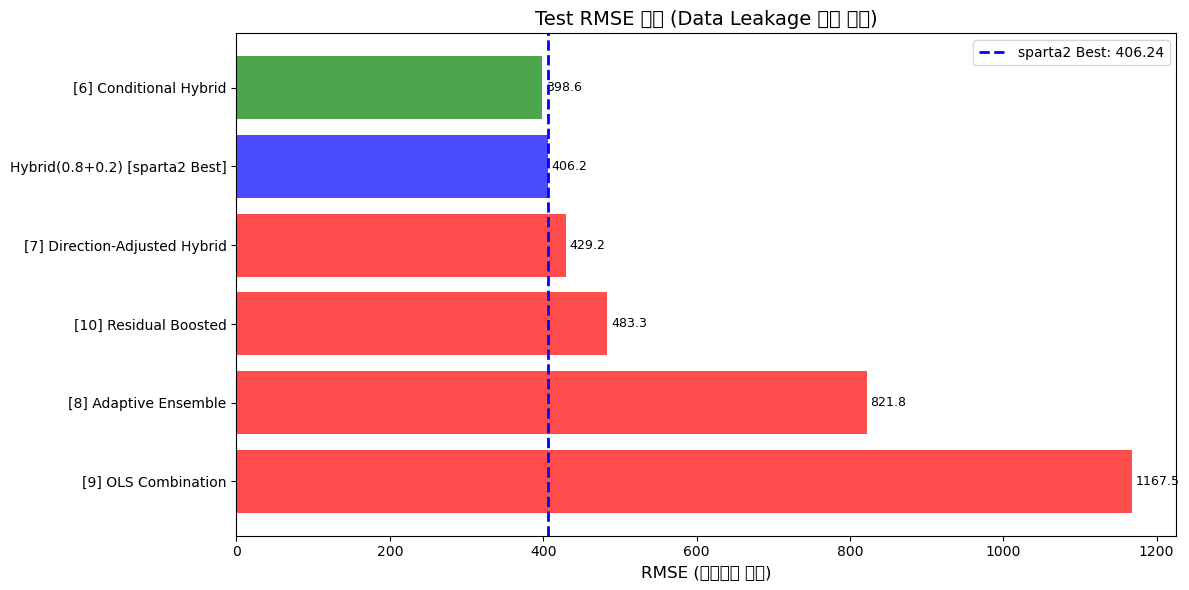

In [24]:
# 10.2 시각화
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['green' if r < SPARTA2_RMSE else 'red' if r > SPARTA2_RMSE else 'blue' for r in final_df['RMSE']]
bars = ax.barh(final_df['Model'], final_df['RMSE'], color=colors, alpha=0.7)

ax.axvline(x=SPARTA2_RMSE, color='blue', linestyle='--', linewidth=2, label=f'sparta2 Best: {SPARTA2_RMSE:.2f}')
ax.set_xlabel('RMSE (낮을수록 좋음)', fontsize=12)
ax.set_title('Test RMSE 비교 (Data Leakage 수정 버전)', fontsize=14)
ax.legend()
ax.invert_yaxis()

for bar, rmse in zip(bars, final_df['RMSE']):
    ax.text(rmse + 5, bar.get_y() + bar.get_height()/2, f'{rmse:.1f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/advanced_fixed_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [25]:
# 10.3 최종 결론
print('='*70)
print('📋 최종 결론 (Data Leakage 수정 버전)')
print('='*70)

print(f'\n🎯 기준선 (sparta2): RMSE = {SPARTA2_RMSE:.2f}')

best_model = final_df.iloc[0]
improvement = SPARTA2_RMSE - best_model['RMSE']
improvement_pct = improvement / SPARTA2_RMSE * 100

print(f'\n🏆 최고 성능: {best_model["Model"]}')
print(f'   RMSE: {best_model["RMSE"]:.2f}')

if improvement > 0:
    print(f'   개선: +{improvement:.2f} (+{improvement_pct:.1f}%)')
else:
    print(f'   기준선 대비 개선 없음')

# 기준선 개선한 모델 수
improved = final_df[final_df['RMSE'] < SPARTA2_RMSE]
print(f'\n✅ 기준선 개선한 기법: {len(improved)}개')

if len(improved) > 0:
    for _, row in improved.iterrows():
        imp = SPARTA2_RMSE - row['RMSE']
        print(f'   • {row["Model"]}: RMSE={row["RMSE"]:.2f} (+{imp:.2f})')

print('\n' + '='*70)
print('⚠️  중요: 이 버전은 Data Leakage를 수정했습니다.')
print('   - 모든 하이퍼파라미터/조합 선택은 Validation 데이터에서만 수행')
print('   - Test 데이터는 최종 평가에만 사용')
print('='*70)

📋 최종 결론 (Data Leakage 수정 버전)

🎯 기준선 (sparta2): RMSE = 406.24

🏆 최고 성능: [6] Conditional Hybrid
   RMSE: 398.58
   개선: +7.66 (+1.9%)

✅ 기준선 개선한 기법: 1개
   • [6] Conditional Hybrid: RMSE=398.58 (+7.66)

⚠️  중요: 이 버전은 Data Leakage를 수정했습니다.
   - 모든 하이퍼파라미터/조합 선택은 Validation 데이터에서만 수행
   - Test 데이터는 최종 평가에만 사용
